<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Constants" data-toc-modified-id="Imports-and-Constants-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Constants</a></span></li><li><span><a href="#Load-histograms-(or-create-if-needed)" data-toc-modified-id="Load-histograms-(or-create-if-needed)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load histograms (or create if needed)</a></span><ul class="toc-item"><li><span><a href="#Split-NL-band" data-toc-modified-id="Split-NL-band-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Split NL band</a></span></li><li><span><a href="#Plot-histograms" data-toc-modified-id="Plot-histograms-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Plot histograms</a></span></li></ul></li><li><span><a href="#Load-folds" data-toc-modified-id="Load-folds-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load folds</a></span><ul class="toc-item"><li><span><a href="#Incountry-folds-+-loc_dict" data-toc-modified-id="Incountry-folds-+-loc_dict-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Incountry folds + loc_dict</a></span></li><li><span><a href="#country_indices-and-country_labels" data-toc-modified-id="country_indices-and-country_labels-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span><code>country_indices</code> and <code>country_labels</code></a></span></li><li><span><a href="#OOC-folds" data-toc-modified-id="OOC-folds-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>OOC folds</a></span></li><li><span><a href="#Urban-v.-Rural" data-toc-modified-id="Urban-v.-Rural-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Urban v. Rural</a></span></li></ul></li><li><span><a href="#Dumb-Baseline-Models" data-toc-modified-id="Dumb-Baseline-Models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dumb Baseline Models</a></span><ul class="toc-item"><li><span><a href="#Incountry:-predict-country-mean" data-toc-modified-id="Incountry:-predict-country-mean-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Incountry: predict country mean</a></span></li><li><span><a href="#KNN-on-Nightlights" data-toc-modified-id="KNN-on-Nightlights-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>KNN on Nightlights</a></span><ul class="toc-item"><li><span><a href="#OOC" data-toc-modified-id="OOC-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>OOC</a></span></li><li><span><a href="#Incountry" data-toc-modified-id="Incountry-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Incountry</a></span></li></ul></li><li><span><a href="#TODO:-KNN-on-Histograms" data-toc-modified-id="TODO:-KNN-on-Histograms-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>TODO: KNN on Histograms</a></span></li></ul></li><li><span><a href="#Ridge-Regression-on-Histograms" data-toc-modified-id="Ridge-Regression-on-Histograms-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Ridge Regression on Histograms</a></span><ul class="toc-item"><li><span><a href="#OOC" data-toc-modified-id="OOC-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>OOC</a></span></li><li><span><a href="#Incountry" data-toc-modified-id="Incountry-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Incountry</a></span></li></ul></li></ul></div>

Prerequisites:
1. Run `preprocessing/analyze_tfrecords_dhs.ipynb`.
2. Run `data_analysis/dhs.ipynb` to create the `dhs_loc_dict.pkl` and `dhs_incountry_folds.pkl`.

# Imports and Constants

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from collections import defaultdict
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import sklearn.neighbors

sys.path.append('../')
from batchers import batcher, dataset_constants
from models.histograms import (
    get_per_image_histograms,
    plot_band_hists,
    plot_label_hist,
    split_nl_hist)
from models.linear_model import ridge_cv
from utils.analysis import calc_score, evaluate
from utils.general import load_npz
from utils.plot import scatter_preds

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

DATASET_NAME = '2009-17'
LABEL_NAME = 'wealthpooled'

FOLDS = ['A', 'B', 'C', 'D', 'E']
SPLITS = ['train', 'val', 'test']
COUNTRIES = dataset_constants.DHS_COUNTRIES

MEANS = dataset_constants.MEANS_DICT[DATASET_NAME]
STD_DEVS = dataset_constants.STD_DEVS_DICT[DATASET_NAME]

LOGS_ROOT_DIR = '../logs/'

# Load histograms (or create if needed)

In [4]:
# BAND_BIN_EDGES = [-10^5, -5.0, -4.9, -4.8, ..., 4.8, 4.9, 5.0, 10^5]
# BAND_BIN_CENTERS = [-5.05, -4.95, -4.85, ..., 4.85, 4.95, 5.05]
BAND_BIN_EDGES = np.concatenate([
    [-1e5],
    np.arange(-5.0, 5.1, 0.1),
    [1e5]
])
BAND_BIN_CENTERS = np.arange(-5.05, 5.15, 0.1)

# LABEL_BIN_EDGES = [-2.0, -1.9, ..., 2.8, 2.9]
# LABEL_BIN_CENTERS = [-1.95, -1.85, ..., 2.75, 2.85]
LABEL_BIN_EDGES = np.arange(-2.0, 3.0, 0.1)
LABEL_BIN_CENTERS = np.arange(-1.95, 2.95, 0.1)

# band name => color for plotting
BAND_COLORS = {
    'BLUE'  : 'blue',
    'GREEN' : 'green',
    'RED'   : 'red',
    'SWIR1' : 'purple',
    'SWIR2' : 'brown',
    'TEMP1' : 'orange',
    'NIR'   : 'pink',
    'NIGHTLIGHTS': 'black',
    'DMSP'  : 'black',
    'VIIRS' : 'gray',
}
BAND_ORDER = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'TEMP1', 'SWIR2', 'NIR', 'NIGHTLIGHTS']
BAND_ORDER_NLSPLIT = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'TEMP1', 'SWIR2', 'NIR', 'DMSP', 'VIIRS']

BANDS_DICT = {
    'rgb': [0, 1, 2],
    'rgbnl': [0, 1, 2, 7, 8],
    'ms': [0, 1, 2, 3, 4, 5, 6],
    'msnl': [0, 1, 2, 3, 4, 5, 6, 7, 8],
    'nl': [7, 8],
}

In [5]:
def get_batcher(tfrecord_files):
    return batcher.Batcher(
        tfrecord_files=tfrecord_files,
        dataset=DATASET_NAME,
        batch_size=128,
        ls_bands='ms',
        nl_band='merge',
        label_name=LABEL_NAME,
        shuffle=False,
        augment=False,
        negatives='zero',
        normalize=True)

In [6]:
file_path = '../data/dhs_image_hists.npz'

if not os.path.exists(file_path):
    # THIS REQUIRES >= 35 GB RAM
    tfrecord_paths = batcher.get_tfrecord_paths(dataset=DATASET_NAME, split='all')
    init_iter, batch_op = get_batcher(tfrecord_paths).get_batch()
    results = get_per_image_histograms(init_iter, batch_op, band_bin_edges=BAND_BIN_EDGES)
    print('Saving image histograms to', file_path)
    np.savez_compressed(file_path, **results)

In [7]:
result = load_npz(file_path)
image_hists = result['image_hists']
labels = result['labels']
locs = result['locs']
years = result['years']
nls_center = result['nls_center']
nls_mean = result['nls_mean']

dmsp_mask = years < 2012
viirs_mask = ~dmsp_mask

image_hists: dtype=int64, shape=(19669, 8, 102)
labels: dtype=float32, shape=(19669,)
locs: dtype=float32, shape=(19669, 2)
years: dtype=int32, shape=(19669,)
nls_center: dtype=float32, shape=(19669,)
nls_mean: dtype=float32, shape=(19669,)


## Split NL band

In [8]:
# split NL band
image_hists = split_nl_hist(image_hists, years)

## Plot histograms

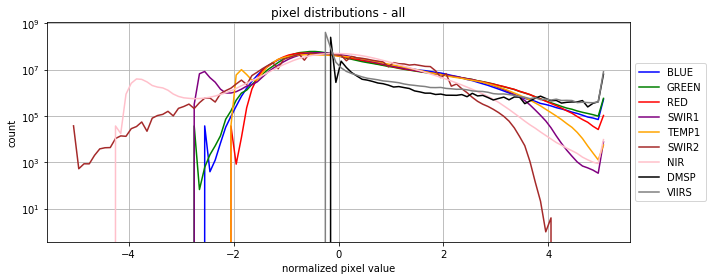

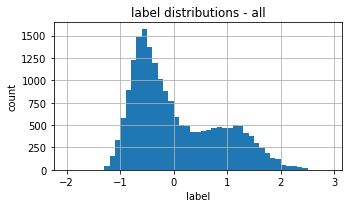

In [9]:
band_hists = np.sum(image_hists, axis=0, dtype=np.int64)  # shape [C, nbins]
plot_band_hists(
    band_hists,
    BAND_ORDER_NLSPLIT,
    band_colors=BAND_COLORS,
    bin_centers=BAND_BIN_CENTERS,
    xlabel='normalized pixel value',
    ylabel='count',
    title='pixel distributions - all',
    yscale='log')
plot_label_hist(
    labels=labels,
    bin_edges=LABEL_BIN_EDGES,
    title='label distributions - all',
    figsize=(5, 3))

# Load folds

## Incountry folds + loc_dict

`loc_dict` has the format:
```python
{
    (lat, lon): {
        'cluster': 1,
        'country': 'malawi',
        'country_year': 'malawi_2012',  # surveyID
        'households': 25,
        'urban': False,
        'wealth': -0.513607621192932,
        'wealthpooled': -0.732255101203918,
        'year': 2012
    }, ...
}
```

NOTE: `year` and `country_year` might differ in the year. `country_year` is the survey ID, which says which year the survey started. However, sometimes the DHS surveys cross the year-boundary, in which case `country_year` will remain the same but `year` will be the next year.

In [10]:
with open('../data/dhs_incountry_folds.pkl', 'rb') as f:
    incountry_folds = pickle.load(f)

with open('../data/dhs_loc_dict.pkl', 'rb') as f:
    loc_dict = pickle.load(f)

incountry_group_labels = np.zeros_like(labels, dtype=np.int32)
for i, f in enumerate(FOLDS):
    test_indices = incountry_folds[f]['test']
    incountry_group_labels[test_indices] = i

## `country_indices` and `country_labels`

`country_indices` is a dictionary that maps a country name to a sorted `np.array` of its indices
```python
{ 'malawi': np.array([ 8530,  8531,  8532, ..., 10484, 10485, 10486]), ... }
```

`country_labels` is a `np.array` that shows which country each example belongs to
```python
np.array([0, 0, 0, 0, ..., 22, 22, 22])
```
where countries are indexed by their position in `dataset_constants.DHS_COUNTRIES`

In [11]:
country_indices = defaultdict(list)  # country => np.array of indices
country_labels = np.zeros(len(locs), dtype=np.int32)  # np.array of country labels

for i, loc in enumerate(locs):
    country = loc_dict[tuple(loc)]['country']
    country_indices[country].append(i)

for i, country in enumerate(COUNTRIES):
    country_indices[country] = np.asarray(country_indices[country])
    indices = country_indices[country]
    country_labels[indices] = i

## OOC folds

In [12]:
# 'A': {
#     'train': np.array([1, 10, 13, ...]),
#     ...
# }
ooc_folds = {
    f: {split: [] for split in SPLITS}
    for f in FOLDS
}

for f in FOLDS:
    surveys_dict = dataset_constants.SURVEY_NAMES[f'2009-17{f}']
    for split, countries in surveys_dict.items():
        split_indices = np.sort(np.concatenate([
            country_indices[country] for country in countries
        ]))
        ooc_folds[f][split] = split_indices

## Urban v. Rural

In [13]:
def get_urban_rural_indices(locs, loc_dict):
    '''
    Args
    - locs: np.array, shape [N, 2]
    - loc_dict: dict, (lat, lon) => dict

    Returns
    - urban_indices: np.array, shape [num_urban]
    - rural_indices: np.array, shape [num_rural]
    '''
    urban_indices = []
    rural_indices = []

    for i, loc in enumerate(locs):
        loc = tuple(loc)
        if loc_dict[loc]['urban'] == 0:
            rural_indices.append(i)
        else:
            urban_indices.append(i)
    urban_indices = np.asarray(urban_indices)
    rural_indices = np.asarray(rural_indices)
    print(f'num urban: {len(urban_indices)}\t num rural: {len(rural_indices)}')
    return urban_indices, rural_indices

urban_indices, rural_indices = get_urban_rural_indices(locs, loc_dict)

num urban: 6801	 num rural: 12868


# Dumb Baseline Models

## Incountry: predict country mean

In [14]:
mean_preds = np.zeros_like(labels)
for i, country in enumerate(COUNTRIES):
    indices = np.where(country_labels == i)[0]
    mean_preds[indices] = np.mean(labels[indices])
r2, _, _, _ = evaluate(labels, mean_preds, do_print=True)

r^2: 0.163, R^2: 0.163, mse: 0.547, rank: 0.419


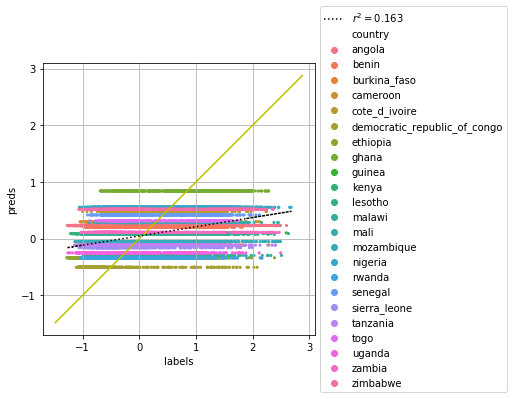

In [15]:
scatter_preds(labels, preds=mean_preds, by_name='country', by_col=np.asarray(COUNTRIES)[country_labels])

## KNN on Nightlights

TODO: proper train/val/test split

In [16]:
def knn_nl(labels, years, nls_center, train_idxs, test_idxs, k=5):
    '''
    Args
    - labels: np.array, shape [N]
    - years: np.array, shape [N]
    - nls_center: np.array, shape [N]
    - splits: dict, split (str) => np.array
    - k: int, k for KNN
    '''
    train_nls = nls_center[train_idxs]

    # test
    test_nls = nls_center[test_idxs]
    test_labels = labels[test_idxs]
    preds = np.zeros_like(test_labels)

    knn_dmsp = sklearn.neighbors.KNeighborsRegressor(k)
    knn_viirs = sklearn.neighbors.KNeighborsRegressor(k)

    dmsp_mask = years < 2012
    viirs_mask = ~dmsp_mask

    for mask, model in [(dmsp_mask, knn_dmsp), (viirs_mask, knn_viirs)]:
        train_mask = mask[train_idxs]
        test_mask = mask[test_idxs]

        # assign each unique NL value the same label
        u, indices = np.unique(train_nls[train_mask], return_inverse=True)
        mean_labels = np.zeros_like(u)
        for i, nl in enumerate(u):
            mean_labels[i] = np.mean(labels[nls_center == nl])

        model.fit(X=train_nls[train_mask].reshape(-1, 1), y=mean_labels[indices])
        preds[test_mask] = model.predict(X=test_nls[test_mask].reshape(-1, 1))

    return preds, knn_dmsp, knn_viirs

In [17]:
def knn_cv_wrapper(labels, years, nls, folds, savepath=None):
    '''
    Args
    - labels: np.array, shape [N]
    - years: np.array, shape [N]
    - nls: np.array, shape [N]
    - folds: dict, folds[f][split] is a np.array of indices

    Returns
    - best_models: tuple of sklearn.neighbors.KNeighborsRegressor
        best models from the last fold
    - test_preds: np.array, shape [N]
    - ks: np.array, shape [K]
    - r2s: np.array, shape [K]
    - R2s: np.array, shape [K]
    - savepath: str, path to save npz file
    '''
    N = len(labels)
    assert len(years) == N
    assert len(nls) == N
    if savepath is not None:
        assert not os.path.exists(savepath)

    test_preds = np.zeros_like(labels)
    ks = np.asarray([1, 2, 5, 10, 30, 50, 100, 200, 500, 1000])
    fold_keys = sorted(folds.keys())
    r2s = np.zeros([len(fold_keys), len(ks)])
    R2s = np.zeros([len(fold_keys), len(ks)])

    dmsp_mask = years < 2012
    viirs_mask = ~dmsp_mask

    for i, f in enumerate(fold_keys):
        test_idxs = folds[f]['test']
        best_models = None

        for j, k in enumerate(ks):
            val_preds, knn_dmsp, knn_viirs = knn_nl(
                labels, years, nls, train_idxs=folds[f]['train'],
                test_idxs=folds[f]['val'], k=k)
            r2 = calc_score(labels=labels[folds[f]['val']], preds=val_preds, metric='r2')
            R2 = calc_score(labels=labels[folds[f]['val']], preds=val_preds, metric='R2')
            if R2 > np.max(R2s[i]):
                best_models = (knn_dmsp, knn_viirs)
            r2s[i, j], R2s[i, j] = r2, R2
            print(f'fold={f}, k={k:4d}, val_r2={r2:0.4f}, val_R2={R2:0.4f}')

        for mask in [dmsp_mask, viirs_mask]:
            idxs = [i for i in test_idxs if mask[i]]
            test_preds[idxs] = best_models[0].predict(nls[idxs].reshape(-1, 1))

    if savepath is not None:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        np.savez_compressed(savepath, test_preds=test_preds, labels=labels)
        
    return best_models, test_preds, ks, r2s, R2s

def plot_knn_val_performance(nl_result, labels, title):
    '''
    Args
    - nl_result: tuple (models, ks, r2s, R2s), output of knn_cv_wrapper
    - labels: np.array
    - title: str
    '''
    _, test_preds, ks, r2s, R2s = nl_result
    evaluate(labels=labels, preds=test_preds, do_print=True, title=f'{title} test')

    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6, 3))
    for i, f in enumerate(FOLDS):
        print(f'fold {f}, chosen k:', ks[np.argmax(R2s[i])])
        axs[0].plot(ks, r2s[i], label=f'fold={f}, $r^2$')
        axs[1].plot(ks, R2s[i], label=f'fold={f}, $R^2$')
    for ax in axs:
        ax.legend()
        ax.grid()
        ax.set(xlabel='k', xscale='log')
    axs[0].set(ylabel='score')
    fig.suptitle(f'{title} validation KNN performance vs. K', y=1.02)
    fig.tight_layout()
    plt.show()

def plot_knn_test(nls_center_result, nls_mean_result, labels,
                  nl0_center_mask, nl0_mean_mask, title):
    '''
    Args
    - *_result: tuple (models, ks, r2s, R2s), output of knn_cv_wrapper
    - labels: np.array, shape [N]
    - *_mask: np.array, shape [N]
    - title: str
    '''
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6, 3))
    results = [nls_center_result, nls_mean_result]
    nl0_masks = [nl0_center_mask, nl0_mean_mask]
    for result, nl0_mask, ax in zip(results, nl0_masks, axs):
        _, test_preds, ks, r2s, R2s = result
        scatter_preds(labels, test_preds, ax=ax)
        ax.scatter(x=labels[nl0_mask], y=test_preds[nl0_mask], c='red', s=2, label='NL = 0')
        ax.legend()
    axs[0].set_title(f'KNN on NL Center ({title})')
    axs[1].set_title(f'KNN on NL Mean ({title})')
    fig.tight_layout()
    plt.show()

In [18]:
def knn_wrapper_single(labels, years, nls, folds):
    '''
    Args
    - labels: np.array, shape [N]
    - years: np.array, shape [N]
    - nls: np.array, shape [N]
    - folds: dict, folds[f][split] is a np.array of indices

    Returns
    - best_model: sklearn.neighbors.KNeighborsRegressor
    - best_test_preds: np.array, shape [N]
    - ks: np.array, shape [K]
    - r2s: np.array, shape [K]
    - R2s: np.array, shape [K]
    '''
    test_preds = np.zeros_like(labels)
    ks = np.asarray([1, 2, 5, 10, 30, 50, 100, 200, 500, 1000])
    r2s = np.zeros(len(ks))
    R2s = np.zeros(len(ks))
    best_test_preds = None

    for i, k in enumerate(ks):
        for f in FOLDS:
            train_idxs = np.concatenate([folds[f]['train'], folds[f]['val']])
            test_idxs = folds[f]['test']
            preds, model = knn_nl(labels, years, nls, k=k, train_idxs=train_idxs, test_idxs=test_idxs)
            test_preds[test_idxs] = preds

        print(f'k={k}, overall - ', end='')
        r2, R2, _, _ = evaluate(labels=labels, preds=test_preds, do_print=True)
        if r2 > np.max(r2s):
            best_test_preds = np.array(test_preds)  # make a copy
            best_model = model
        r2s[i], R2s[i] = r2, R2

    return best_model, best_test_preds, ks, r2s, R2s

In [19]:
DMSP0 = -MEANS['DMSP'] / STD_DEVS['DMSP']
VIIRS0 = -MEANS['VIIRS'] / STD_DEVS['VIIRS']
nl0_center_mask = ((nls_center == DMSP0) & dmsp_mask) | ((nls_center == VIIRS0) & viirs_mask)
nl0_mean_mask = ((nls_mean == DMSP0) & dmsp_mask) | ((nls_mean == VIIRS0) & viirs_mask)

### OOC

In [20]:
nls_center_result = knn_cv_wrapper(
    labels=labels, years=years, nls=nls_center, folds=ooc_folds,
    savepath=os.path.join(LOGS_ROOT_DIR, 'dhs_knn', 'nls_center', 'test_preds.npz'))

nls_mean_result = knn_cv_wrapper(
    labels=labels, years=years, nls=nls_mean, folds=ooc_folds,
    savepath=os.path.join(LOGS_ROOT_DIR, 'dhs_knn', 'nls_mean', 'test_preds.npz'))

fold=A, k=   1, val_r2=0.4577, val_R2=0.2894
fold=A, k=   2, val_r2=0.5453, val_R2=0.4786
fold=A, k=   5, val_r2=0.6090, val_R2=0.5815
fold=A, k=  10, val_r2=0.6384, val_R2=0.6208
fold=A, k=  30, val_r2=0.6591, val_R2=0.6450
fold=A, k=  50, val_r2=0.6656, val_R2=0.6523
fold=A, k= 100, val_r2=0.6689, val_R2=0.6565
fold=A, k= 200, val_r2=0.6717, val_R2=0.6601
fold=A, k= 500, val_r2=0.6711, val_R2=0.6630
fold=A, k=1000, val_r2=0.6674, val_R2=0.6661
fold=B, k=   1, val_r2=0.4715, val_R2=0.4033
fold=B, k=   2, val_r2=0.5543, val_R2=0.5310
fold=B, k=   5, val_r2=0.6120, val_R2=0.6027
fold=B, k=  10, val_r2=0.6334, val_R2=0.6255
fold=B, k=  30, val_r2=0.6481, val_R2=0.6393
fold=B, k=  50, val_r2=0.6499, val_R2=0.6413
fold=B, k= 100, val_r2=0.6515, val_R2=0.6424
fold=B, k= 200, val_r2=0.6521, val_R2=0.6419
fold=B, k= 500, val_r2=0.6487, val_R2=0.6326
fold=B, k=1000, val_r2=0.6212, val_R2=0.5752
fold=C, k=   1, val_r2=0.5003, val_R2=0.4595
fold=C, k=   2, val_r2=0.5618, val_R2=0.5456
fold=C, k=

NL center test	- r^2: 0.541, R^2: 0.440, mse: 0.365, rank: 0.583
fold A, chosen k: 1000
fold B, chosen k: 100
fold C, chosen k: 100
fold D, chosen k: 200
fold E, chosen k: 1000


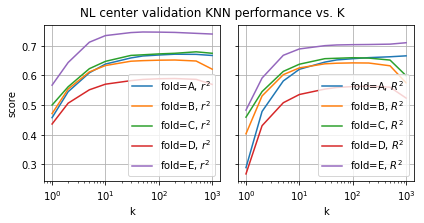

NL mean test	- r^2: 0.557, R^2: 0.450, mse: 0.359, rank: 0.623
fold A, chosen k: 500
fold B, chosen k: 100
fold C, chosen k: 200
fold D, chosen k: 100
fold E, chosen k: 1000


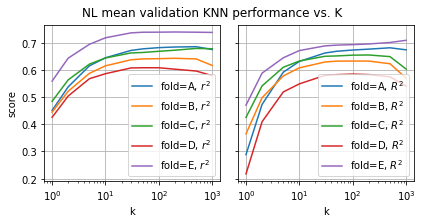

In [21]:
plot_knn_val_performance(nls_center_result, labels, title='NL center')
plot_knn_val_performance(nls_mean_result, labels, title='NL mean')

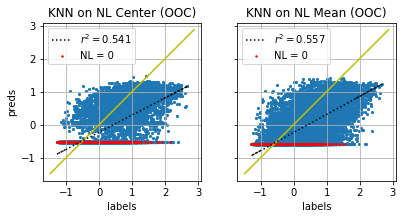

In [22]:
plot_knn_test(nls_center_result, nls_mean_result, labels,
              nl0_center_mask, nl0_mean_mask, title='OOC')

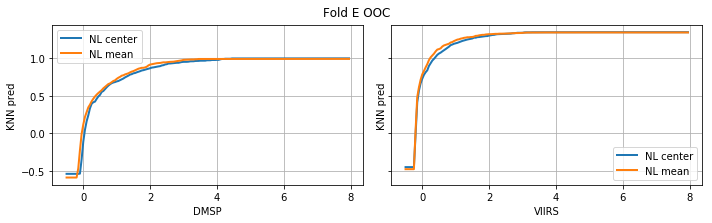

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
for result, title in [(nls_center_result, 'NL center'),
                      (nls_mean_result, 'NL mean')]:
    models = result[0]
    masks = [dmsp_mask, viirs_mask]
    for i in range(2):
        ax, mask, model = axs[i], masks[i], models[i]
        nls = np.arange(-0.5, 8, 0.05)
        preds = model.predict(nls.reshape(-1, 1))
        ax.plot(nls, preds, linewidth=2, label=title)

axs[0].set(xlabel='DMSP', ylabel='KNN pred')
axs[1].set(xlabel='VIIRS', ylabel='KNN pred')

for ax in axs:
    ax.grid(True)
    ax.legend()
fig.suptitle('Fold E OOC', y=1.02)
fig.tight_layout()
plt.show()

### Incountry

In [24]:
nls_center_result = knn_cv_wrapper(
    labels=labels, years=years, nls=nls_center, folds=incountry_folds,
    savepath=os.path.join(LOGS_ROOT_DIR, 'dhs_knn', 'incountry_nls_center', 'test_preds.npz'))

nls_mean_result = knn_cv_wrapper(
    labels=labels, years=years, nls=nls_mean, folds=incountry_folds,
    savepath=os.path.join(LOGS_ROOT_DIR, 'dhs_knn', 'incountry_nls_mean', 'test_preds.npz'))

fold=A, k=   1, val_r2=0.4895, val_R2=0.4178
fold=A, k=   2, val_r2=0.5685, val_R2=0.5424
fold=A, k=   5, val_r2=0.6210, val_R2=0.6097
fold=A, k=  10, val_r2=0.6377, val_R2=0.6295
fold=A, k=  30, val_r2=0.6510, val_R2=0.6465
fold=A, k=  50, val_r2=0.6546, val_R2=0.6506
fold=A, k= 100, val_r2=0.6556, val_R2=0.6521
fold=A, k= 200, val_r2=0.6560, val_R2=0.6532
fold=A, k= 500, val_r2=0.6548, val_R2=0.6535
fold=A, k=1000, val_r2=0.6496, val_R2=0.6427
fold=B, k=   1, val_r2=0.5016, val_R2=0.4268
fold=B, k=   2, val_r2=0.5788, val_R2=0.5556
fold=B, k=   5, val_r2=0.6404, val_R2=0.6330
fold=B, k=  10, val_r2=0.6598, val_R2=0.6545
fold=B, k=  30, val_r2=0.6729, val_R2=0.6679
fold=B, k=  50, val_r2=0.6748, val_R2=0.6700
fold=B, k= 100, val_r2=0.6754, val_R2=0.6701
fold=B, k= 200, val_r2=0.6751, val_R2=0.6691
fold=B, k= 500, val_r2=0.6757, val_R2=0.6661
fold=B, k=1000, val_r2=0.6576, val_R2=0.6238
fold=C, k=   1, val_r2=0.4655, val_R2=0.3755
fold=C, k=   2, val_r2=0.5443, val_R2=0.5162
fold=C, k=

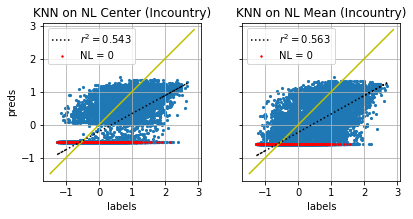

In [25]:
plot_knn_test(nls_center_result, nls_mean_result, labels,
              nl0_center_mask, nl0_mean_mask, title='Incountry')

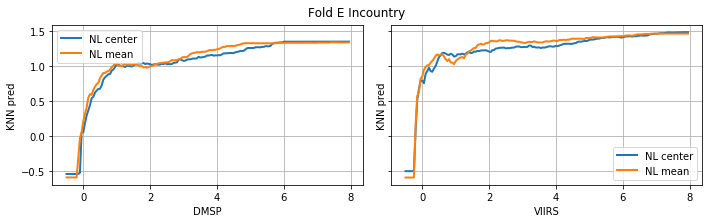

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
for result, title in [(nls_center_result, 'NL center'),
                      (nls_mean_result, 'NL mean')]:
    models = result[0]
    masks = [dmsp_mask, viirs_mask]
    for i in range(2):
        ax, mask, model = axs[i], masks[i], models[i]
        nls = np.arange(-0.5, 8, 0.05)
        preds = model.predict(nls.reshape(-1, 1))
        ax.plot(nls, preds, linewidth=2, label=title)

axs[0].set(xlabel='DMSP', ylabel='KNN pred')
axs[1].set(xlabel='VIIRS', ylabel='KNN pred')

for ax in axs:
    ax.grid(True)
    ax.legend()
fig.suptitle('Fold E Incountry', y=1.02)
fig.tight_layout()
plt.show()

## TODO: KNN on Histograms

# Ridge Regression on Histograms

- set "missing" DMSP and VIIRS values to the mean
- not sure if this is the most "correct" thing to do, but it's somewhat reasonable approximation

In [16]:
# standardize to 0 mean and unit variance
num_examples = len(image_hists)
image_hists_mean = np.mean(image_hists, axis=0, dtype=np.float64)
image_hists_std = np.std(image_hists, axis=0, dtype=np.float64)

image_hists_mean[7] = np.mean(image_hists[dmsp_mask, 7], axis=0, dtype=np.float64)
image_hists_mean[8] = np.mean(image_hists[viirs_mask, 8], axis=0, dtype=np.float64)

image_hists_std[7] = np.std(image_hists[dmsp_mask, 7], axis=0, dtype=np.float64)
image_hists_std[8] = np.std(image_hists[viirs_mask, 8], axis=0, dtype=np.float64)

normalized_image_hists = np.zeros(image_hists.shape, dtype=np.float64)
for mask in [dmsp_mask, viirs_mask]:
    normalized_image_hists[mask] = (image_hists[mask] - image_hists_mean) / (image_hists_std + 1e-6)

print(normalized_image_hists.shape)

(19669, 9, 102)


In [17]:
def split_nls(nls, years):
    '''
    Args
    - nls: np.array, shape [N]
    - years: np.array, shape [N]

    Returns
    - nls_split: np.array, shape [N, 2]
    '''
    N = len(nls)
    dmsp_mask = years < 2012
    viirs_mask = ~dmsp_mask
    nls_split = np.zeros([N, 2], dtype=np.float32)
    nls_split[dmsp_mask, 0] = nls[dmsp_mask]
    nls_split[viirs_mask, 1] = nls[viirs_mask]
    return nls_split

In [18]:
normalized_nls_center = split_nls(nls_center, years)
for i, mask in enumerate([dmsp_mask, viirs_mask]):
    normalized_nls_center[mask, i] -= np.mean(normalized_nls_center[mask, i])
    normalized_nls_center[mask, i] -= np.std(normalized_nls_center[mask, i])

normalized_nls_mean = split_nls(nls_mean, years)
for i, mask in enumerate([dmsp_mask, viirs_mask]):
    normalized_nls_mean[mask, i] -= np.mean(normalized_nls_mean[mask, i])
    normalized_nls_mean[mask, i] -= np.std(normalized_nls_mean[mask, i])

## OOC

In [19]:
def run_ridge_ooc_wrapper(img_hists, model_name):
    print(model_name)
    ridge_cv(
        features=img_hists.reshape(num_examples, -1),
        labels=labels, group_labels=country_labels, group_names=COUNTRIES,
        savedir=os.path.join(LOGS_ROOT_DIR, 'dhs_ridge', model_name))
    print(f'== {model_name} urban ==')
    ridge_cv(
        features=img_hists.reshape(num_examples, -1),
        labels=labels, group_labels=country_labels, group_names=COUNTRIES,
        savedir=os.path.join(LOGS_ROOT_DIR, 'dhs_ridge', model_name),
        subset_indices=urban_indices, subset_name='urban')
    print(f'== {model_name} rural ==')
    ridge_cv(
        features=img_hists.reshape(num_examples, -1),
        labels=labels, group_labels=country_labels, group_names=COUNTRIES,
        savedir=os.path.join(LOGS_ROOT_DIR, 'dhs_ridge', model_name),
        subset_indices=rural_indices, subset_name='rural')

In [20]:
model_name = 'nlcenter_scalar'
run_ridge_ooc_wrapper(model_name=model_name, img_hists=normalized_nls_center)

nlcenter_scalar
Group: angola
best val mse: 0.428, best alpha: 128.0, test mse: 2.242
Group: benin
best val mse: 0.505, best alpha: 8192.0, test mse: 0.384
Group: burkina_faso
best val mse: 0.510, best alpha: 8192.0, test mse: 0.285
Group: cameroon
best val mse: 0.498, best alpha: 8192.0, test mse: 0.581
Group: cote_d_ivoire
best val mse: 0.502, best alpha: 8192.0, test mse: 0.397
Group: democratic_republic_of_congo
best val mse: 0.498, best alpha: 8192.0, test mse: 0.615
Group: ethiopia
best val mse: 0.491, best alpha: 8192.0, test mse: 0.673
Group: ghana
best val mse: 0.491, best alpha: 8192.0, test mse: 0.781
Group: guinea
best val mse: 0.499, best alpha: 8192.0, test mse: 0.585
Group: kenya
best val mse: 0.513, best alpha: 8192.0, test mse: 0.391
Group: lesotho
best val mse: 0.506, best alpha: 8192.0, test mse: 0.368
Group: malawi
best val mse: 0.522, best alpha: 8192.0, test mse: 0.320
Group: mali
best val mse: 0.506, best alpha: 8192.0, test mse: 0.345
Group: mozambique
best val 

In [33]:
model_name = 'nlmean_scalar'
run_ridge_ooc_wrapper(model_name=model_name, img_hists=normalized_nls_mean)

nlmean_scalar
best val mse: 0.429, best alpha: 128.0, test mse: 2.223
best val mse: 0.516, best alpha: 8192.0, test mse: 0.385
best val mse: 0.521, best alpha: 8192.0, test mse: 0.291
best val mse: 0.508, best alpha: 8192.0, test mse: 0.593
best val mse: 0.512, best alpha: 8192.0, test mse: 0.429
best val mse: 0.508, best alpha: 8192.0, test mse: 0.651
best val mse: 0.502, best alpha: 8192.0, test mse: 0.697
best val mse: 0.502, best alpha: 8192.0, test mse: 0.798
best val mse: 0.509, best alpha: 8192.0, test mse: 0.614
best val mse: 0.524, best alpha: 8192.0, test mse: 0.402
best val mse: 0.516, best alpha: 8192.0, test mse: 0.377
best val mse: 0.532, best alpha: 8192.0, test mse: 0.337
best val mse: 0.516, best alpha: 8192.0, test mse: 0.364
best val mse: 0.517, best alpha: 8192.0, test mse: 0.417
best val mse: 0.487, best alpha: 8192.0, test mse: 0.795
best val mse: 0.521, best alpha: 8192.0, test mse: 0.342
best val mse: 0.508, best alpha: 8192.0, test mse: 0.578
best val mse: 0.51

In [34]:
model_name = 'rgb_hist'
run_ridge_ooc_wrapper(model_name=model_name, img_hists=normalized_image_hists[:, :3, :])

rgb_hist
best val mse: 0.543, best alpha: 8192.0, test mse: 0.945
best val mse: 0.571, best alpha: 8192.0, test mse: 0.318
best val mse: 0.558, best alpha: 8192.0, test mse: 0.617
best val mse: 0.562, best alpha: 8192.0, test mse: 0.562
best val mse: 0.561, best alpha: 8192.0, test mse: 0.519
best val mse: 0.561, best alpha: 8192.0, test mse: 0.478
best val mse: 0.541, best alpha: 8192.0, test mse: 0.895
best val mse: 0.551, best alpha: 8192.0, test mse: 0.860
best val mse: 0.561, best alpha: 8192.0, test mse: 0.465
best val mse: 0.562, best alpha: 1024.0, test mse: 0.549
best val mse: 0.571, best alpha: 8192.0, test mse: 0.306
best val mse: 0.584, best alpha: 8192.0, test mse: 0.355
best val mse: 0.566, best alpha: 8192.0, test mse: 0.403
best val mse: 0.565, best alpha: 8192.0, test mse: 0.478
best val mse: 0.548, best alpha: 8192.0, test mse: 0.784
best val mse: 0.573, best alpha: 1024.0, test mse: 0.337
best val mse: 0.559, best alpha: 8192.0, test mse: 0.599
best val mse: 0.562, b

In [35]:
model_name = 'rgbnl_hist'
bands = [0, 1, 2, -2, -1]
run_ridge_ooc_wrapper(model_name=model_name, img_hists=normalized_image_hists[:, bands, :])

rgbnl_hist
best val mse: 0.228, best alpha: 1024.0, test mse: 0.365
best val mse: 0.234, best alpha: 1024.0, test mse: 0.172
best val mse: 0.237, best alpha: 1024.0, test mse: 0.131
best val mse: 0.227, best alpha: 1024.0, test mse: 0.372
best val mse: 0.232, best alpha: 1024.0, test mse: 0.210
best val mse: 0.232, best alpha: 1024.0, test mse: 0.231
best val mse: 0.233, best alpha: 1024.0, test mse: 0.163
best val mse: 0.232, best alpha: 1024.0, test mse: 0.237
best val mse: 0.234, best alpha: 1024.0, test mse: 0.187
best val mse: 0.235, best alpha: 1024.0, test mse: 0.199
best val mse: 0.236, best alpha: 1024.0, test mse: 0.134
best val mse: 0.235, best alpha: 1024.0, test mse: 0.193
best val mse: 0.224, best alpha: 1024.0, test mse: 0.363
best val mse: 0.237, best alpha: 1024.0, test mse: 0.132
best val mse: 0.230, best alpha: 1024.0, test mse: 0.304
best val mse: 0.233, best alpha: 1024.0, test mse: 0.164
best val mse: 0.239, best alpha: 1024.0, test mse: 0.159
best val mse: 0.233,

In [36]:
model_name = 'ms_hist'
run_ridge_ooc_wrapper(model_name=model_name, img_hists=normalized_image_hists[:, :7, :])

ms_hist
best val mse: 0.483, best alpha: 1024.0, test mse: 0.544
best val mse: 0.490, best alpha: 1024.0, test mse: 0.237
best val mse: 0.486, best alpha: 1024.0, test mse: 0.350
best val mse: 0.483, best alpha: 1024.0, test mse: 0.485
best val mse: 0.482, best alpha: 1024.0, test mse: 0.404
best val mse: 0.487, best alpha: 1024.0, test mse: 0.306
best val mse: 0.439, best alpha: 1024.0, test mse: 0.979
best val mse: 0.478, best alpha: 1024.0, test mse: 0.577
best val mse: 0.481, best alpha: 1024.0, test mse: 0.340
best val mse: 0.485, best alpha: 1024.0, test mse: 0.480
best val mse: 0.485, best alpha: 1024.0, test mse: 0.339
best val mse: 0.491, best alpha: 1024.0, test mse: 0.364
best val mse: 0.488, best alpha: 1024.0, test mse: 0.303
best val mse: 0.492, best alpha: 1024.0, test mse: 0.312
best val mse: 0.468, best alpha: 1024.0, test mse: 0.722
best val mse: 0.487, best alpha: 1024.0, test mse: 0.314
best val mse: 0.473, best alpha: 1024.0, test mse: 0.725
best val mse: 0.477, be

In [37]:
model_name = 'msnl_hist'
run_ridge_ooc_wrapper(model_name=model_name, img_hists=normalized_image_hists)

msnl_hist
best val mse: 0.244, best alpha: 1024.0, test mse: 0.361
best val mse: 0.248, best alpha: 1024.0, test mse: 0.181
best val mse: 0.252, best alpha: 1024.0, test mse: 0.130
best val mse: 0.238, best alpha: 1024.0, test mse: 0.433
best val mse: 0.247, best alpha: 1024.0, test mse: 0.202
best val mse: 0.247, best alpha: 1024.0, test mse: 0.225
best val mse: 0.244, best alpha: 1024.0, test mse: 0.300
best val mse: 0.247, best alpha: 1024.0, test mse: 0.237
best val mse: 0.247, best alpha: 1024.0, test mse: 0.168
best val mse: 0.249, best alpha: 1024.0, test mse: 0.237
best val mse: 0.244, best alpha: 1024.0, test mse: 0.249
best val mse: 0.250, best alpha: 1024.0, test mse: 0.205
best val mse: 0.250, best alpha: 1024.0, test mse: 0.146
best val mse: 0.250, best alpha: 1024.0, test mse: 0.204
best val mse: 0.237, best alpha: 1024.0, test mse: 0.381
best val mse: 0.248, best alpha: 1024.0, test mse: 0.174
best val mse: 0.243, best alpha: 1024.0, test mse: 0.337
best val mse: 0.246, 

In [38]:
model_name = 'nl_hist'
run_ridge_ooc_wrapper(model_name=model_name, img_hists=normalized_image_hists[:, -2:, :])

nl_hist
best val mse: 0.223, best alpha: 128.0, test mse: 0.365
best val mse: 0.232, best alpha: 1024.0, test mse: 0.162
best val mse: 0.234, best alpha: 1024.0, test mse: 0.126
best val mse: 0.225, best alpha: 1024.0, test mse: 0.377
best val mse: 0.229, best alpha: 1024.0, test mse: 0.228
best val mse: 0.229, best alpha: 1024.0, test mse: 0.271
best val mse: 0.228, best alpha: 1024.0, test mse: 0.260
best val mse: 0.229, best alpha: 1024.0, test mse: 0.246
best val mse: 0.230, best alpha: 1024.0, test mse: 0.171
best val mse: 0.230, best alpha: 1024.0, test mse: 0.223
best val mse: 0.232, best alpha: 1024.0, test mse: 0.186
best val mse: 0.234, best alpha: 1024.0, test mse: 0.190
best val mse: 0.232, best alpha: 1024.0, test mse: 0.158
best val mse: 0.233, best alpha: 1024.0, test mse: 0.201
best val mse: 0.217, best alpha: 1024.0, test mse: 0.385
best val mse: 0.235, best alpha: 1024.0, test mse: 0.128
best val mse: 0.226, best alpha: 1024.0, test mse: 0.348
best val mse: 0.232, bes

## Incountry

In [17]:
def ridge_incountry_wrapper(img_hists, model_name):
    print(model_name)
    ridge_cv(
        features=img_hists.reshape(num_examples, -1), labels=labels,
        group_labels=incountry_group_labels, group_names=FOLDS,
        savedir=os.path.join(LOGS_ROOT_DIR, 'dhs_ridge', model_name))
    print(f'== {model_name} urban ==')
    ridge_cv(
        features=img_hists.reshape(num_examples, -1), labels=labels,
        group_labels=incountry_group_labels, group_names=FOLDS,
        savedir=os.path.join(LOGS_ROOT_DIR, 'dhs_ridge', model_name),
        subset_indices=urban_indices, subset_name='urban')
    print(f'== {model_name} rural ==')
    ridge_cv(
        features=img_hists.reshape(num_examples, -1), labels=labels,
        group_labels=incountry_group_labels, group_names=FOLDS,
        savedir=os.path.join(LOGS_ROOT_DIR, 'dhs_ridge', model_name),
        subset_indices=rural_indices, subset_name='rural')

In [18]:
model_name = 'incountry_nlcenter_scalar'
ridge_incountry_wrapper(model_name=model_name, img_hists=normalized_nls_center)

incountry_nlcenter_scalar
Group: A
best val mse: 0.497, best alpha: 8192.0, test mse: 0.503
Group: B
best val mse: 0.440, best alpha: 1024.0, test mse: 0.661
Group: C
best val mse: 0.504, best alpha: 8192.0, test mse: 0.476
Group: D
best val mse: 0.503, best alpha: 8192.0, test mse: 0.487
Group: E
best val mse: 0.502, best alpha: 8192.0, test mse: 0.495
saving test preds to: ../logs/dhs_ridge/incountry_nlcenter_scalar/test_preds.npz
== incountry_nlcenter_scalar urban ==
Group: A
best val mse: 0.385, best alpha: 1024.0, test mse: 0.448
Group: B
best val mse: 0.379, best alpha: 1024.0, test mse: 0.466
Group: C
best val mse: 0.411, best alpha: 8192.0, test mse: 0.356
Group: D
best val mse: 0.402, best alpha: 8192.0, test mse: 0.395
Group: E
best val mse: 0.406, best alpha: 8192.0, test mse: 0.392
saving test preds to: ../logs/dhs_ridge/incountry_nlcenter_scalar/test_preds_urban.npz
== incountry_nlcenter_scalar rural ==
Group: A
best val mse: 0.214, best alpha: 16.0, test mse: 0.195
Group:

In [19]:
model_name = 'incountry_nlmean_scalar'
ridge_incountry_wrapper(model_name=model_name, img_hists=normalized_nls_mean)

incountry_nlmean_scalar
Fold: A
best val mse: 0.503, best alpha: 1024.0, test mse: 0.478
Fold: B
best val mse: 0.436, best alpha: 128.0, test mse: 0.748
Fold: C
best val mse: 0.520, best alpha: 8192.0, test mse: 0.493
Fold: D
best val mse: 0.516, best alpha: 1024.0, test mse: 0.459
Fold: E
best val mse: 0.512, best alpha: 1024.0, test mse: 0.449
saving test preds to: ../logs/dhs_ridge/incountry_nlmean_scalar/test_preds.npz
== incountry_nlmean_scalar urban ==
Fold: A
best val mse: 0.384, best alpha: 1024.0, test mse: 0.448
Fold: B
best val mse: 0.376, best alpha: 128.0, test mse: 0.537
Fold: C
best val mse: 0.410, best alpha: 1024.0, test mse: 0.353
Fold: D
best val mse: 0.405, best alpha: 1024.0, test mse: 0.382
Fold: E
best val mse: 0.409, best alpha: 1024.0, test mse: 0.364
saving test preds to: ../logs/dhs_ridge/incountry_nlmean_scalar/test_preds_urban.npz
== incountry_nlmean_scalar rural ==
Fold: A
best val mse: 0.219, best alpha: 128.0, test mse: 0.197
Fold: B
best val mse: 0.223,

In [20]:
model_name = 'incountry_rgb_hist'
ridge_incountry_wrapper(model_name=model_name, img_hists=normalized_image_hists[:, :3, :])

incountry_rgb_hist
Fold: A
best val mse: 0.522, best alpha: 1024.0, test mse: 0.561
Fold: B
best val mse: 0.533, best alpha: 1024.0, test mse: 0.531
Fold: C
best val mse: 0.544, best alpha: 1024.0, test mse: 0.504
Fold: D
best val mse: 0.527, best alpha: 1024.0, test mse: 0.544
Fold: E
best val mse: 0.539, best alpha: 1024.0, test mse: 0.507
saving test preds to: ../logs/dhs_ridge/incountry_rgb_hist/test_preds.npz
== incountry_rgb_hist urban ==
Fold: A
best val mse: 0.391, best alpha: 8192.0, test mse: 0.469
Fold: B
best val mse: 0.397, best alpha: 8192.0, test mse: 0.434
Fold: C
best val mse: 0.416, best alpha: 8192.0, test mse: 0.373
Fold: D
best val mse: 0.398, best alpha: 1024.0, test mse: 0.428
Fold: E
best val mse: 0.421, best alpha: 8192.0, test mse: 0.353
saving test preds to: ../logs/dhs_ridge/incountry_rgb_hist/test_preds_urban.npz
== incountry_rgb_hist rural ==
Fold: A
best val mse: 0.235, best alpha: 1024.0, test mse: 0.217
Fold: B
best val mse: 0.242, best alpha: 1024.0, t

In [21]:
model_name = 'incountry_rgbnl_hist'
bands = [0, 1, 2, -2, -1]
ridge_incountry_wrapper(model_name=model_name, img_hists=normalized_image_hists[:, bands, :])

incountry_rgbnl_hist
Fold: A
best val mse: 0.222, best alpha: 1024.0, test mse: 0.222
Fold: B
best val mse: 0.222, best alpha: 1024.0, test mse: 0.236
Fold: C
best val mse: 0.230, best alpha: 1024.0, test mse: 0.211
Fold: D
best val mse: 0.222, best alpha: 1024.0, test mse: 0.222
Fold: E
best val mse: 0.224, best alpha: 1024.0, test mse: 0.213
saving test preds to: ../logs/dhs_ridge/incountry_rgbnl_hist/test_preds.npz
== incountry_rgbnl_hist urban ==
Fold: A
best val mse: 0.283, best alpha: 1024.0, test mse: 0.309
Fold: B
best val mse: 0.283, best alpha: 1024.0, test mse: 0.323
Fold: C
best val mse: 0.307, best alpha: 1024.0, test mse: 0.245
Fold: D
best val mse: 0.280, best alpha: 1024.0, test mse: 0.311
Fold: E
best val mse: 0.299, best alpha: 1024.0, test mse: 0.246
saving test preds to: ../logs/dhs_ridge/incountry_rgbnl_hist/test_preds_urban.npz
== incountry_rgbnl_hist rural ==
Fold: A
best val mse: 0.157, best alpha: 1024.0, test mse: 0.154
Fold: B
best val mse: 0.161, best alpha:

In [22]:
model_name = 'incountry_ms_hist'
ridge_incountry_wrapper(model_name=model_name, img_hists=normalized_image_hists[:, :7, :])

incountry_ms_hist
Fold: A
best val mse: 0.400, best alpha: 1024.0, test mse: 0.491
Fold: B
best val mse: 0.438, best alpha: 1024.0, test mse: 0.394
Fold: C
best val mse: 0.426, best alpha: 1024.0, test mse: 0.399
Fold: D
best val mse: 0.423, best alpha: 1024.0, test mse: 0.422
Fold: E
best val mse: 0.433, best alpha: 1024.0, test mse: 0.382
saving test preds to: ../logs/dhs_ridge/incountry_ms_hist/test_preds.npz
== incountry_ms_hist urban ==
Fold: A
best val mse: 0.353, best alpha: 1024.0, test mse: 0.428
Fold: B
best val mse: 0.369, best alpha: 8192.0, test mse: 0.371
Fold: C
best val mse: 0.375, best alpha: 8192.0, test mse: 0.345
Fold: D
best val mse: 0.361, best alpha: 1024.0, test mse: 0.388
Fold: E
best val mse: 0.383, best alpha: 8192.0, test mse: 0.319
saving test preds to: ../logs/dhs_ridge/incountry_ms_hist/test_preds_urban.npz
== incountry_ms_hist rural ==
Fold: A
best val mse: 0.222, best alpha: 8192.0, test mse: 0.210
Fold: B
best val mse: 0.232, best alpha: 8192.0, test m

In [23]:
model_name = 'incountry_msnl_hist'
ridge_incountry_wrapper(model_name=model_name, img_hists=normalized_image_hists)

incountry_msnl_hist
Fold: A
best val mse: 0.220, best alpha: 1024.0, test mse: 0.235
Fold: B
best val mse: 0.227, best alpha: 1024.0, test mse: 0.232
Fold: C
best val mse: 0.231, best alpha: 1024.0, test mse: 0.216
Fold: D
best val mse: 0.226, best alpha: 1024.0, test mse: 0.218
Fold: E
best val mse: 0.227, best alpha: 1024.0, test mse: 0.214
saving test preds to: ../logs/dhs_ridge/incountry_msnl_hist/test_preds.npz
== incountry_msnl_hist urban ==
Fold: A
best val mse: 0.285, best alpha: 1024.0, test mse: 0.324
Fold: B
best val mse: 0.292, best alpha: 1024.0, test mse: 0.330
Fold: C
best val mse: 0.317, best alpha: 8192.0, test mse: 0.278
Fold: D
best val mse: 0.290, best alpha: 1024.0, test mse: 0.313
Fold: E
best val mse: 0.313, best alpha: 1024.0, test mse: 0.249
saving test preds to: ../logs/dhs_ridge/incountry_msnl_hist/test_preds_urban.npz
== incountry_msnl_hist rural ==
Fold: A
best val mse: 0.155, best alpha: 1024.0, test mse: 0.160
Fold: B
best val mse: 0.163, best alpha: 1024

In [24]:
model_name = 'incountry_nl_hist'
ridge_incountry_wrapper(model_name=model_name, img_hists=normalized_image_hists[:, -2:, :])

incountry_nl_hist
Fold: A
best val mse: 0.227, best alpha: 1024.0, test mse: 0.223
Fold: B
best val mse: 0.223, best alpha: 1024.0, test mse: 0.245
Fold: C
best val mse: 0.232, best alpha: 128.0, test mse: 0.215
Fold: D
best val mse: 0.226, best alpha: 1024.0, test mse: 0.225
Fold: E
best val mse: 0.226, best alpha: 128.0, test mse: 0.225
saving test preds to: ../logs/dhs_ridge/incountry_nl_hist/test_preds.npz
== incountry_nl_hist urban ==
Fold: A
best val mse: 0.286, best alpha: 1024.0, test mse: 0.296
Fold: B
best val mse: 0.278, best alpha: 1024.0, test mse: 0.328
Fold: C
best val mse: 0.304, best alpha: 1024.0, test mse: 0.246
Fold: D
best val mse: 0.278, best alpha: 1024.0, test mse: 0.307
Fold: E
best val mse: 0.294, best alpha: 1024.0, test mse: 0.251
saving test preds to: ../logs/dhs_ridge/incountry_nl_hist/test_preds_urban.npz
== incountry_nl_hist rural ==
Fold: A
best val mse: 0.162, best alpha: 128.0, test mse: 0.160
Fold: B
best val mse: 0.164, best alpha: 128.0, test mse: 